# Задание 4 - Перенос обучения (transfer learning) и тонкая настройка (fine-tuning)

Одной из важнейшних техник в тренировке сетей - использовать заранее натренированные веса на более общей задачи в качестве начальной точки, а потом "дотренировать" их на конкретной.

Такой подход и убыстряет обучение, и позволяет тренировать эффективные модели на маленьких наборах данных.

В этом упражнении мы натренируем классификатор, который отличает хотдоги от не хотдогов!  
(более подробно - https://www.youtube.com/watch?v=ACmydtFDTGs)

Это задание требует доступа к GPU, поэтому его можно выполнять либо на компьютере с GPU от NVidia, либо в [Google Colab](https://colab.research.google.com/).

In [1]:
import json
import os
import csv
import urllib
from io import BytesIO
from PIL import Image
from PIL import ImageOps
from socket import timeout

from google.colab import files
!pip3 install --upgrade scikit-image
!pip3 install -q torch torchvision
!pip3 install -q Pillow


Requirement already up-to-date: scikit-image in /usr/local/lib/python3.6/dist-packages (0.16.2)


Сначала давайте скачаем данные с картинками. Это сделает код в следующей ячейке. Данные будут разделены на две части. На обучающей выборке, которая будет храниться в папке **train_kaggle**, мы будем строить наши модели, а на тестовой выборке **test_kaggle** будем предсказывать класс, к которому относится фотография (хотдог или нет).

### Если вы в Google Colab!

В нем можно запускать ноутбуки с доступом к GPU. Они не очень быстрые, зато бесплатные!
Каждый ноутбук получает свой собственный environment c доступным диском итд.

Через 90 минут отсуствия активности этот environment пропадает со всеми данными.
Поэтому нам придется скачивать данные каждый раз.

In [2]:
# Download train data
!wget "https://storage.googleapis.com/dlcourse_ai/train.zip"
!unzip -q "train.zip"

train_folder = "train_kaggle/"
# Count number of files in the train folder, should be 4603
print('Number of files in the train folder', len(os.listdir(train_folder)))

# Download test data
!wget "https://storage.googleapis.com/dlcourse_ai/test.zip"
!unzip -q "test.zip"

test_folder = "test_kaggle/"
# Count number of files in the test folder, should be 1150
print('Number of files in the test folder', len(os.listdir(test_folder)))

--2020-03-22 17:29:51--  https://storage.googleapis.com/dlcourse_ai/train.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.194.128, 2607:f8b0:4001:c00::80
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.194.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 562348083 (536M) [application/zip]
Saving to: ‘train.zip’

train.zip           100%[===================>] 536.30M  48.7MB/s    in 13s     

2020-03-22 17:30:05 (39.8 MB/s) - ‘train.zip’ saved [562348083/562348083]

Number of files in the train folder 4603
--2020-03-22 17:30:11--  https://storage.googleapis.com/dlcourse_ai/test.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.212.128, 2607:f8b0:4001:c05::80
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.212.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 140788786 (134M) [application/zip]
Saving to: ‘test.zip’

test.zip            100%[

In [0]:
import torch
from types import *

from torch.utils.data import Dataset, SubsetRandomSampler

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from torchvision import transforms
from torchvision import models

device = torch.device("cuda:0") # Let's make sure GPU is available!

# Имплементируем свой Dataset для загрузки данных

В этом задании мы реализуем свой собственный класс Dataset для загрузки данных. Его цель - загрузить данные с диска и выдать по ним тензор с входом сети, меткой и идентификатором картинки (так будет проще подготовить сабмит для kaggle на тестовых данных).

Вот ссылка, где хорошо объясняется как это делать на примере: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

Ваш Dataset должен в качестве количества сэмплов выдать количество файлов в папке и уметь выдавать кортеж из сэмпла, метки по индексу и названия файла.
Если название файла начинается со слов 'frankfurter', 'chili-dog' или 'hotdog' - метка положительная. Иначе отрицательная (ноль).

И не забудьте поддержать возможность трансформации входа (аргумент `transforms`), она нам понадобится!

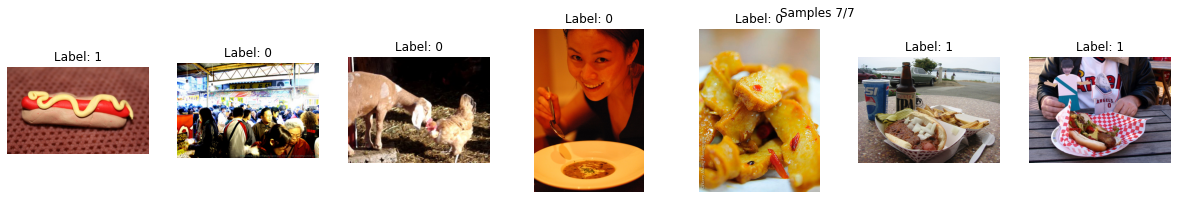

In [19]:
class HotdogOrNotDataset(Dataset):
    def __init__(self, folder, transform=None):
        self.transform = transform
        self.folder = folder
        self.files = os.listdir(train_folder)

    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, index):        
        # TODO Implement getting item by index
        # Hint: os.path.join is helpful!
        img_name = os.path.join(self.folder, self.files[index])
        img = Image.open(img_name)
        
        if self.transform:
            img = self.transform(img)
        file_name = self.files[index]
        y = 0
        if ('frankfurter' in file_name) or ('chili-dog' in file_name) or ('hotdog' in file_name):
            y = 1
        return img, y, index

def visualize_samples(dataset, indices, title=None, count=10):
    # visualize random 10 samples
    plt.figure(figsize=(count*3,3))
    display_indices = indices[:count]
    if title:
        plt.suptitle("%s %s/%s" % (title, len(display_indices), len(indices)))        
    for i, index in enumerate(display_indices):    
        x, y, _ = dataset[index]
        plt.subplot(1,count,i+1)
        plt.title("Label: %s" % y)
        plt.imshow(x)
        plt.grid(False)
        plt.axis('off')   
    
orig_dataset = HotdogOrNotDataset(train_folder)
indices = np.random.choice(np.arange(len(orig_dataset)), 7, replace=False)

visualize_samples(orig_dataset, indices, "Samples")

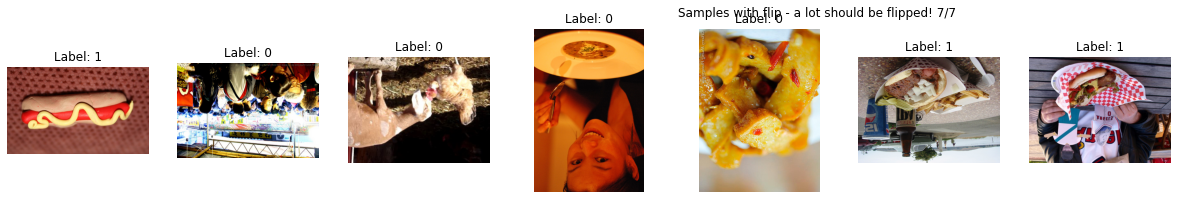

In [21]:
# Let's make sure transforms work!
dataset = HotdogOrNotDataset(train_folder, transform=transforms.RandomVerticalFlip(0.9))

visualize_samples(dataset, indices, "Samples with flip - a lot should be flipped!")

# Создаем Dataset для тренировки

И разделяем его на train и validation.
На train будем обучать модель, на validation проверять ее качество, а соревнование Kaggle In-Class проведем на фотографиях из папки test_kaggle.

In [0]:
# First, lets load the dataset
train_dataset = HotdogOrNotDataset(train_folder, 
                       transform=transforms.Compose([
                           transforms.Resize((224, 224)),
                           transforms.ToTensor(),
                           # Use mean and std for pretrained models
                           # https://pytorch.org/docs/stable/torchvision/models.html
                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])                         
                       ])
                      )
test_dataset = HotdogOrNotDataset(test_folder, 
                       transform=transforms.Compose([
                           transforms.Resize((224, 224)),
                           transforms.ToTensor(),
                           # Use mean and std for pretrained models
                           # https://pytorch.org/docs/stable/torchvision/models.html
                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])                         
                       ])
                      )

In [0]:
batch_size = 64

data_size = len(dataset)
validation_fraction = .2


val_split = int(np.floor((validation_fraction) * data_size))
indices = list(range(data_size))
np.random.seed(42)
np.random.shuffle(indices)

val_indices, train_indices = indices[:val_split], indices[val_split:]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                         sampler=val_sampler)
# Notice that we create test data loader in a different way. We don't have the labels.
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

Наши обычные функции для тренировки

In [0]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y,_) in enumerate(train_loader):
          
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)    
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    # TODO: Copy implementation from previous assignment
    # Don't forget to move the data to device before running it through the model!
    model.eval() # Evaluation mode
    correct, total = 0, 0
    for x, y, _ in loader:
        x_gpu = x.to(device)
        y_gpu = y.to(device)
        output = model(x_gpu)
        predicted = torch.argmax(output.data, 1)
        total += y_gpu.shape[0]
        correct += (predicted == y_gpu).sum().item()
    return correct / total

# Использование заранее натренированной сети (pretrained network)

Чаще всего в качестве заранее натренированной сети используется сеть, натренированная на данных ImageNet с 1M изображений и 1000 классами.

PyTorch включает такие натренированные сети для различных архитектур (https://pytorch.org/docs/stable/torchvision/models.html)  
Мы будем использовать ResNet18.

Для начала посмотрим, что выдает уже натренированная сеть на наших картинках. То есть, посмотрим к какому из 1000 классов их отнесет сеть.

Запустите модель на 10 случайных картинках из датасета и выведите их вместе с классами с наибольшей вероятностью.  
В коде уже есть код, который формирует соответствие между индексами в выходном векторе и классами ImageNet.

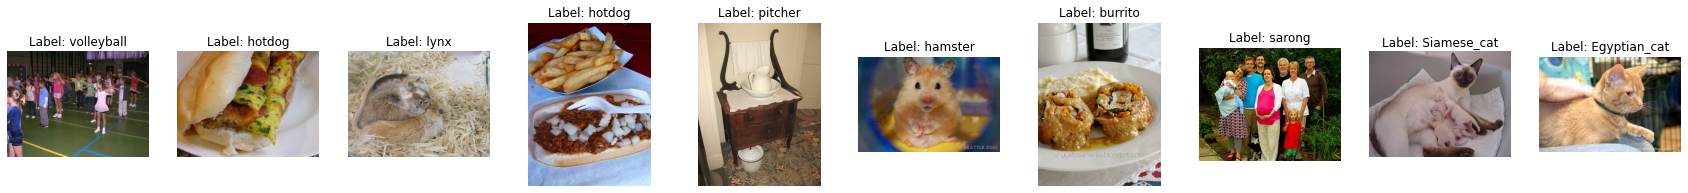

In [25]:
from torchvision.transforms.functional import to_pil_image
# Thanks to https://discuss.pytorch.org/t/imagenet-classes/4923/2
def load_imagenet_classes():
    classes_json = urllib.request.urlopen('https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json').read()
    classes = json.loads(classes_json)
    
    # TODO: Process it to return dict of class index to name
    return { int(k): v[-1] for k, v in classes.items()}
    
model = models.resnet18(pretrained=True)

# # TODO: Run this model on 10 random images of your dataset and visualize what it predicts
  
indices = np.random.choice(np.arange(len(train_loader)), 10, replace=False)
resnet_data = [train_dataset[i][0] for i in indices]
batch = torch.stack(resnet_data)

model.eval()
out = model(batch)
_, index = torch.max(out, 1)

index = index.detach().numpy()
classes = load_imagenet_classes()
predicted_classes = [classes[i] for i in index]

def visualize_samples_predicted(dataset, indices, predicted, count=10):
    # visualize random 10 samples
    plt.figure(figsize=(count*3,3))
    display_indices = indices[:count]
     
    for i, index in enumerate(display_indices):    
        x, y, _ = dataset[index]
        plt.subplot(1,count,i+1)
        plt.title("Label: %s" % predicted[i])
        plt.imshow(x)
        plt.grid(False)
        plt.axis('off')   

visualize_samples_predicted(orig_dataset, indices, predicted_classes)

# Перенос обучения (transfer learning) - тренировать только последний слой

Существует несколько вариантов переноса обучения, мы попробуем основные.  
Первый вариант - заменить последний слой на новый и тренировать только его, заморозив остальные.

In [28]:
import torch.nn as nn
import torch.optim as optim

model = models.resnet18(pretrained=True)
# TODO: Freeze all the layers of this model and add a new output layer
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model = model.to(device)

parameters = model.fc.parameters() 

loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(parameters, lr=0.001, momentum=0.9)
loss_history, train_history, val_history = train_model(model, train_loader, val_loader, loss, optimizer, 2)

Average loss: 0.379949, Train accuracy: 0.821884, Val accuracy: 0.910870
Average loss: 0.208742, Train accuracy: 0.921803, Val accuracy: 0.908696


# Перенос обучения (transfer learning) - тренировать всю модель

Второй вариант - точно так же заменить последгний слой на новый и обучать всю модель целиком.

In [29]:
import torch.nn as nn
import torch.optim as optim

model = models.resnet18(pretrained=True)
# TODO: Add a new output layer and train the whole model
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model = model.to(device)

parameters = model.parameters()
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD( parameters, lr=0.001, momentum=0.9)

loss_history, train_history, val_history = train_model(model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 0.323187, Train accuracy: 0.845506, Val accuracy: 0.926087
Average loss: 0.136109, Train accuracy: 0.946511, Val accuracy: 0.936957
Average loss: 0.096426, Train accuracy: 0.969862, Val accuracy: 0.936957
Average loss: 0.073306, Train accuracy: 0.975020, Val accuracy: 0.936957
Average loss: 0.052345, Train accuracy: 0.983980, Val accuracy: 0.946739


# Перенос обучения (transfer learning) - разные скорости обучения для разных слоев

И наконец последний вариант, который мы рассмотрим - использовать разные скорости обучения для новых и старых слоев

In [31]:
import torch.nn as nn
import torch.optim as optim

model = models.resnet18(pretrained=True)
# TODO: Add a new output layer
# Train new layer with learning speed 0.001 and old layers with 0.0001
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model = model.to(device)

loss = nn.CrossEntropyLoss()


optimizer = optim.SGD([{'params': model.parameters(), 'lr': 1e-3}], lr=1e-4, momentum=0.9)
# Hint - look into what PyTorch optimizers let you configure!
loss_history, train_history, val_history = train_model(model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 0.321498, Train accuracy: 0.851208, Val accuracy: 0.927174
Average loss: 0.137195, Train accuracy: 0.948683, Val accuracy: 0.933696
Average loss: 0.096052, Train accuracy: 0.967418, Val accuracy: 0.941304
Average loss: 0.070725, Train accuracy: 0.979093, Val accuracy: 0.942391
Average loss: 0.047056, Train accuracy: 0.988053, Val accuracy: 0.941304


# Визуализируем метрики и ошибки модели

Попробуем посмотреть, где модель ошибается - визуализируем ложные срабатывания (false positives) и ложноотрицательные срабатывания (false negatives).

Для этого мы прогоним модель через все примеры и сравним ее с истинными метками (ground truth).

In [0]:
from torch.utils.data.sampler import Sampler

class SubsetSampler(Sampler):
    r"""Samples elements with given indices sequentially

    Arguments:
        data_source (Dataset): dataset to sample from
        indices (ndarray): indices of the samples to take
    """

    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return (self.indices[i] for i in range(len(self.indices)))

    def __len__(self):
        return len(self.indices)
    
    
def evaluate_model(model, dataset, indices):
    """
    Computes predictions and ground truth labels for the indices of the dataset
    
    Returns: 
    predictions: np array of booleans of model predictions
    grount_truth: np array of boolean of actual labels of the dataset
    """
    model.eval() # Evaluation mode
    
    # TODO: Evaluate model on the list of indices and capture predictions
    # and ground truth labels
    # Hint: SubsetSampler above could be useful!
    
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=64)
    correct, total = 0, 0
    predictions = np.array([]).astype(bool)
    ground_truth = np.array([]).astype(bool)
    for x, y, _ in data_loader:
        x_gpu = x.to(device)
        y_gpu = y.to(device)
        output = torch.argmax(model(x_gpu).data, 1)
        output = output.cpu().numpy()
        predictions = np.append(predictions, output.astype(bool))
        ground_truth = np.append(ground_truth, y_gpu.cpu().numpy().astype(bool))
    return predictions, ground_truth

predictions, gt = evaluate_model(model, train_dataset, val_indices)

И теперь можно визуализировать false positives и false negatives.

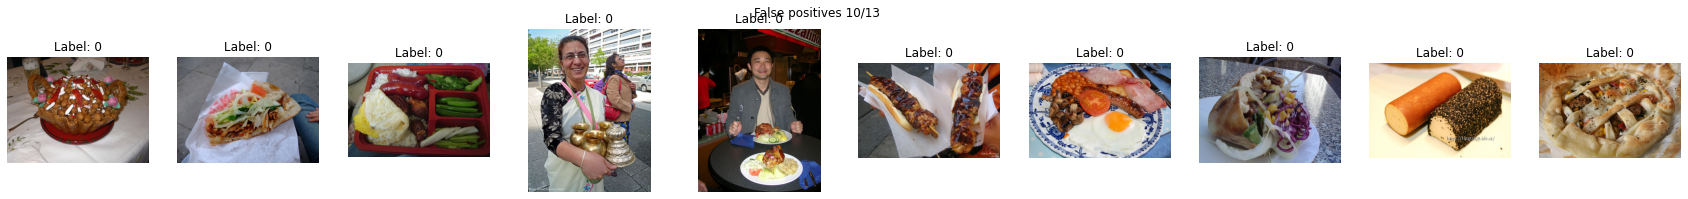

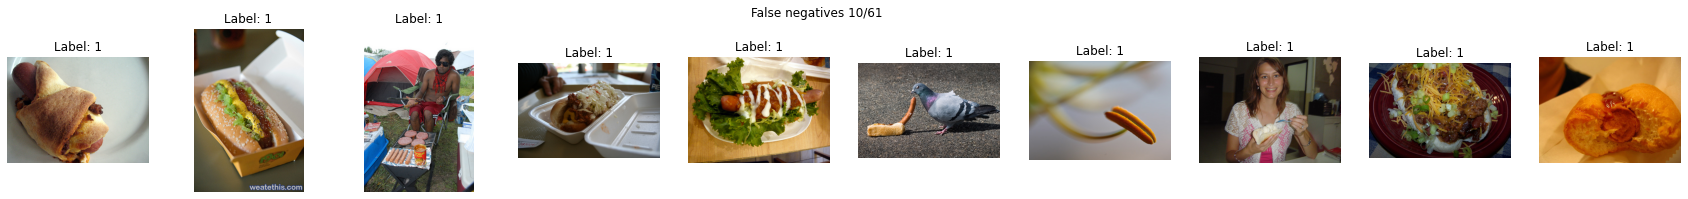

In [40]:
false_positive_indices = [i for i, pred in enumerate(predictions) if pred == True and pred != gt[i]]
visualize_samples(orig_dataset, false_positive_indices, "False positives")


false_negatives_indices = [i for i, pred in enumerate(predictions) if pred == False and pred != gt[i]]
visualize_samples(orig_dataset, false_negatives_indices, "False negatives")


In [41]:
import sklearn.metrics as metrics

def binary_classification_metrics(prediction, ground_truth):
    precision = 0
    recall = 0
    f1 = 0

    tp = 0
    tn = 0
    fp = 0
    fn = 0

    for i in range(prediction.shape[0]):
        if prediction[i]:
            if ground_truth[i]:
                tp += 1
            else:
                fp += 1
        else:
            if ground_truth[i]:
                fn += 1
            else:
                tn += 1
    if tp + fp != 0:
        precision = tp / (tp + fp)
    if tp + fn != 0:
        recall = tp / (tp + fn)
    if precision + recall != 0:
        f1 = 2 * precision * recall / (precision + recall)

    return precision, recall, f1

precision, recall, f1 = binary_classification_metrics(predictions, gt)
print("F1: %4.3f, P: %4.3f, R: %4.3f" % (f1, precision, recall))

F1: 0.974, P: 0.991, R: 0.958


# Что будет в конце вы уже поняли

Натренируйте лучшую модель на основе `resnet18`, меняя только процесс тренировки.
Выбирайте лучшую модель по F1 score.

Как всегда, не забываем:
- побольше агментаций!
- перебор гиперпараметров
- различные оптимизаторы
- какие слои тюнить
- learning rate annealing
- на какой эпохе останавливаться

Наша цель - довести F1 score на validation set до значения, большего **0.93**.

In [51]:
# TODO: Train your best model!
# import torch.nn as nn
# import torch.optim as optim
best_model = None


momentum = [0.9, 0.95]
lr = [1e-3, 1e-4]
best_f1 = 0
for m in momentum:
  for l in lr:
    model = models.resnet18(pretrained=True)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 2)
    model.to(device)
    parameters = model.parameters()
    loss = nn.CrossEntropyLoss()
    print("Lr:", l, "Momentum:", m)
    optimizer = optim.SGD(parameters, lr=l, momentum=m)
    loss_history, train_history, val_history = train_model(model, train_loader, val_loader, loss, optimizer, 10)
    predictions, ground_truth = evaluate_model(model, train_dataset, val_indices)
    precision, recall, f1 = binary_classification_metrics(predictions, ground_truth)
    if f1 > best_f1:
      best_f1 = f1
      best_model = model
      best_train_history = train_history
      best_val_history = val_history
      print("new f1", round(f1, 3))

Lr: 0.001 Momentum: 0.9
Average loss: 0.281642, Train accuracy: 0.879446, Val accuracy: 0.923913
Average loss: 0.132318, Train accuracy: 0.954657, Val accuracy: 0.938043
Average loss: 0.095770, Train accuracy: 0.967146, Val accuracy: 0.940217
Average loss: 0.074699, Train accuracy: 0.974749, Val accuracy: 0.944565
Average loss: 0.059178, Train accuracy: 0.982623, Val accuracy: 0.951087
Average loss: 0.035002, Train accuracy: 0.991311, Val accuracy: 0.947826
Average loss: 0.026605, Train accuracy: 0.995384, Val accuracy: 0.943478
Average loss: 0.020405, Train accuracy: 0.997285, Val accuracy: 0.948913
Average loss: 0.012035, Train accuracy: 0.999728, Val accuracy: 0.945652
Average loss: 0.013118, Train accuracy: 0.998642, Val accuracy: 0.950000
new f1 0.984
Lr: 0.0001 Momentum: 0.9
Average loss: 0.584427, Train accuracy: 0.699973, Val accuracy: 0.813043
Average loss: 0.372843, Train accuracy: 0.852023, Val accuracy: 0.875000
Average loss: 0.300731, Train accuracy: 0.893294, Val accuracy

F1: 0.988, P: 0.980, R: 0.984


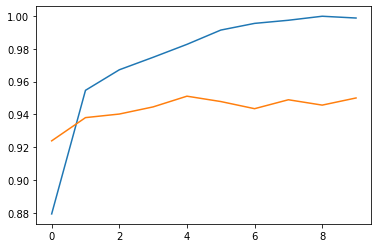

In [52]:
# Let's check how it performs on validation set!
predictions, ground_truth = evaluate_model(best_model, train_dataset, val_indices)
precision, recall, f1 = binary_classification_metrics(predictions, ground_truth)
print("F1: %4.3f, P: %4.3f, R: %4.3f" % (precision, recall, f1))

plt.plot(best_train_history)
plt.plot(best_val_history)

## Визуализируйте ошибки лучшей модели

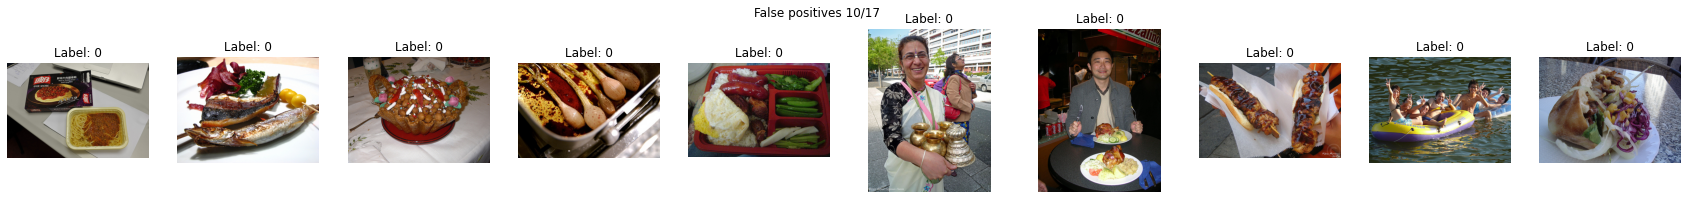

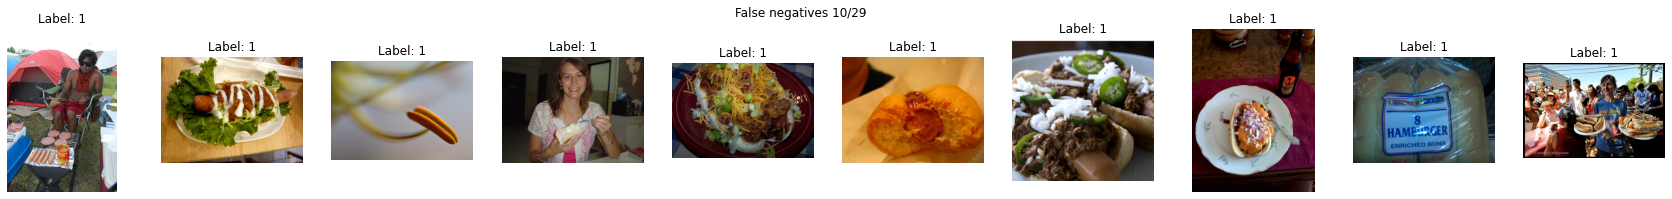

In [53]:
# TODO Visualize false positives and false negatives of the best model on the validation set
false_positive_indices = [i for i, pred in enumerate(predictions) if pred == True and pred != ground_truth[i]]
visualize_samples(orig_dataset, false_positive_indices, "False positives")


false_negatives_indices = [i for i, pred in enumerate(predictions) if pred == False and pred != ground_truth[i]]
visualize_samples(orig_dataset, false_negatives_indices, "False negatives")